In [8]:
import librosa
import numpy as np
import soundfile as sf
import os as os
import glob
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchvision.models as models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
def trim_silence(file_path, top_db=20):
    try:
        y, sr = librosa.load(file_path, sr=16000, mono=True)
        y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
        return y_trimmed, sr
    except Exception as e:
        print(f"{os.path.basename(file_path)}")
        return None, None

base_dir = os.path.expanduser("~/Desktop/AUDIO_FILES")
output_base_dir = os.path.expanduser("~/Desktop/TRIMMED_AUDIO")

for actor_num in range(1, 25):
    input_dir = os.path.join(base_dir, f"Actor_{actor_num:02d}", f"Actor_{actor_num:02d}")
    output_dir = os.path.join(output_base_dir, f"Actor_{actor_num:02d}", f"Actor_{actor_num:02d}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    
    file_count = 0
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.wav'):
            file_path = os.path.join(input_dir, file_name)
            output_file = os.path.join(output_dir, file_name)
            
            result = trim_silence(file_path)
            if result[0] is not None:
                sf.write(output_file, result[0], result[1])
                file_count += 1
    
    


In [10]:
def augment_audio(audio, sr):
    if np.random.rand() > 0.5:  # 50% chance: Add noise
        noise = np.random.randn(len(audio))  # Random white noise same length
        audio += 0.005 * noise  # Scale noise (0.5% amplitude)
        audio = np.clip(audio, -1., 1.)  # Prevent clipping
    
    if np.random.rand() > 0.5:  # 50% chance: Time stretch
        rate = 0.8 + 0.4 * np.random.rand()  # Random rate 0.8-1.2x
        audio = librosa.effects.time_stretch(audio, rate=rate)  # Stretch/compress
    
    if np.random.rand() > 0.5:  # 50% chance: Pitch shift
        steps = np.random.randint(-4, 5)  # Random -4 to +4 semitones
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)
    
    return audio  # Modified audio (1-3 augmentations applied)

In [11]:
def wav_to_logmel(wav_path):
    audio, sr = librosa.load(wav_path, sr=16000)  # Load WAV at 16kHz
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, hop_length=512)
    # ^ Creates 128 frequency bins, 512-sample hops → ~173 time steps for 3s
    log_mel = librosa.power_to_db(mel)  # dB scale (-80 to 0 typically)
    if log_mel.shape[1] > 173:  # Too long? Trim
        return log_mel[:, :173]
    else:  # Too short? Pad with zeros
        pad_w = 173 - log_mel.shape[1]
        return np.pad(log_mel, ((0,0), (0, pad_w)), mode='constant')


In [12]:
TRIMMED_DIR = os.path.expanduser("~/Desktop/TRIMMED_AUDIO/")
AUG_DIR = os.path.expanduser("~/Desktop/AUGMENTED_AUDIO/")
MEL_DIR = os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/")
os.makedirs(AUG_DIR, exist_ok=True)
os.makedirs(MEL_DIR, exist_ok=True)

train_actors = [f"Actor_{i:02}" for i in range(1, 25)] 

emotion_map = {'01':0, '02':1, '03':2,'04':3,'05':4 ,'06':5, '07':6, '08':7}
all_audio_paths = []  
all_labels = []      

for actor in train_actors:  # Loop 24 actors
    actor_path = os.path.join(TRIMMED_DIR, actor, actor) 
    aug_path = os.path.join(AUG_DIR, actor)              
    os.makedirs(aug_path, exist_ok=True)                 
    
    for wav_file in glob.glob(os.path.join(actor_path, "*.wav")):
        audio, sr = librosa.load(wav_file, sr=16000)  
        base = os.path.splitext(os.path.basename(wav_file))[0]  
        label = emotion_map[wav_file.split('-')[2]] 
        
        # Save ORIGINAL as _orig.wav
        orig_aug_path = os.path.join(aug_path, f"{base}_orig.wav")
        sf.write(orig_aug_path, audio, sr)
        all_audio_paths.append(orig_aug_path)
        all_labels.append(label)
        
        
        for i in range(3):
            aug_audio = augment_audio(audio, sr)
            aug_file_path = os.path.join(aug_path, f"{base}_aug{i}.wav")
            sf.write(aug_file_path, aug_audio, sr)
            all_audio_paths.append(aug_file_path)
            all_labels.append(label)


In [20]:
os.makedirs(MEL_DIR, exist_ok=True)

mel_spectrograms = []
mel_labels = []

for i, (audio_path, label) in enumerate(zip(all_audio_paths, all_labels)):
    
    
    log_mel = wav_to_logmel(audio_path)  # Shape: (128, 173)
    mel_spectrograms.append(log_mel)
    mel_labels.append(label)


X = np.array(mel_spectrograms)
y = np.array(mel_labels)

np.save(os.path.join(MEL_DIR, "X_mel.npy"), X)
np.save(os.path.join(MEL_DIR, "y_labels.npy"), y)


In [14]:
X = np.load(os.path.join(MEL_DIR, "X_mel.npy"))
y = np.load(os.path.join(MEL_DIR, "y_labels.npy"))

print(f"Total dataset: {X.shape}, Emotions: {np.bincount(y)}")

# 80/10/10 SPLIT → STRATIFIED by emotion (10% per emotion to val/test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42  # 10% test
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111111, stratify=y_temp, random_state=42  # 11.11% of 90% = 10%
)

# Verify EXACT 80/10/10 + balanced emotions
np.save(os.path.join(MEL_DIR, "X_train.npy"), X_train)
np.save(os.path.join(MEL_DIR, "y_train.npy"), y_train)
np.save(os.path.join(MEL_DIR, "X_val.npy"), X_val)
np.save(os.path.join(MEL_DIR, "y_val.npy"), y_val)
np.save(os.path.join(MEL_DIR, "X_test.npy"), X_test)
np.save(os.path.join(MEL_DIR, "y_test.npy"), y_test)
print("\n✅ 80/10/10 SPLIT VERIFICATION:")
print(f"Train:   {X_train.shape} → {np.bincount(y_train)}")  # 80%
print(f"Val:     {X_val.shape}   → {np.bincount(y_val)}")    # 10%
print(f"Test:    {X_test.shape}  → {np.bincount(y_test)}")   # 10%
print(f"Total:   {len(y_train)+len(y_val)+len(y_test)} == {len(y)} ✓")

#=======PRE-PROCESSING COMPLETE=========#

Total dataset: (5760, 128, 173), Emotions: [384 768 768 768 768 768 768 768]

✅ 80/10/10 SPLIT VERIFICATION:
Train:   (4608, 128, 173) → [308 615 615 614 614 614 614 614]
Val:     (576, 128, 173)   → [38 77 76 77 77 77 77 77]
Test:    (576, 128, 173)  → [38 76 77 77 77 77 77 77]
Total:   5760 == 5760 ✓


In [21]:
#We may use the validation set to determine which CNN Architecture performs the best
#I shall compare between two architectures: LeNet-5 and AlexNet, as described in the book by Aurelien Geron
#Both the CNNs will be trained on the training data and tested against the validation data
#Whichever performs better shall be re-trained on combination of training and validation data and tested against testing data

class LeNet5_Dropout(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        
        # BLOCK 1: C1 + S2 (Conv2D + Pooling)
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),           # C1: 128×173 → 128×173×6 ✓
            nn.Tanh(),                               # LeNet activation
            nn.AvgPool2d(2, 2)                       # S2: → 64×86×6 ✓
        )
        
        # BLOCK 2: C3 + S4 (Conv2D + Pooling)  
        self.block2 = nn.Sequential(
            nn.Conv2d(6, 16, 5, padding=2),          # C3: 64×86 → 64×86×16 ✓
            nn.Tanh(),
            nn.AvgPool2d(2, 2)                       # S4: → 32×43×16 ✓
        )
        
        # BLOCK 3: C5 (Conv2D → Flatten)
        self.block3 = nn.Sequential(
            nn.Conv2d(16, 120, 5, padding=2),        # C5: 32×43 → 32×43×120 ✓
            nn.Tanh()
        )
        
        # Phase 2: GlobalAvgPool + Dropout ✓
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)              # F6 dropout ✓
        
        # F6 + Output (LeNet classifier + Phase 2 dropout)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120, 84),                      # F6 ✓
            nn.Tanh(),
            nn.Dropout(0.5),                         # Between layers ✓
            nn.Linear(84, num_classes)               # 8 emotions
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)                      # Phase 2 GAP ✓
        x = self.dropout1(x)
        x = self.classifier(x)
        return x

# Instantiate
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model = LeNet5_Dropout(8).to(device)



In [22]:
import torch.nn as nn

class AlexNet_Emotions(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        
        # BLOCK 1: Large stride conv + maxpool (AlexNet signature)
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 96, 11, stride=4, padding=2),   # C1: 128×173→32×43×96
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),                   # S2: →15×21×96
            nn.BatchNorm2d(96)                           # Phase 2 ✓
        )
        
        # BLOCK 2: 5×5 convs (parallel in original, sequential here)
        self.block2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, padding=2),            # C2: 15×21→15×21×256
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),                   # S3: →7×10×256
            nn.BatchNorm2d(256)                          # Phase 2 ✓
        )
        
        # BLOCKS 3-5: 3×3 convs (AlexNet modernization)
        self.block3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(384)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(384)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(3, stride=2), nn.BatchNorm2d(256)  # Pooling ✓
        )
        
        # Phase 2: GAP + Dropout
        self.global_pool = nn.AdaptiveAvgPool2d(1)       # GAP ✓
        
        # AlexNet FC layers + Phase 2 Dropout ✓
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), nn.Linear(256, 4096), nn.ReLU(),  # FC6
            nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(), # FC7
            nn.Dropout(0.3), nn.Linear(4096, num_classes)      # FC8: 8 emotions
        )
    
    def forward(self, x):
        x = self.block1(x)  # 128×173 → 15×21×96
        x = self.block2(x)  # 15×21 → 7×10×256
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)  # 7×10 → 3×4×256
        x = self.global_pool(x)  # GAP → 1×1×256 ✓
        x = self.classifier(x)
        return x

# Test it
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
alexnet = AlexNet_Emotions(8).to(device)



In [23]:
X_train = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_train.npy"))[:, np.newaxis, :, :]
X_val = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_val.npy"))[:, np.newaxis, :, :]
y_train = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_train.npy"))
y_val = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_val.npy"))

X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

In [53]:
def train_model(model_class, epochs=20, lr=0.001):
    model = model_class(8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_f1 = 0
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Val F1 (macro for imbalanced emotions)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_preds = val_outputs.argmax(dim=1).cpu().numpy()
            val_f1 = f1_score(y_val, val_preds, average='macro')
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={train_loss/len(train_loader):.3f}, Val F1={val_f1:.3f}")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_{model_class.__name__}.pth")
    
    print(f"✅ Best Val F1: {best_f1:.3f}")
    return model


In [54]:
print("=== LeNet-5 Training ===")
lenet_model = train_model(LeNet5_Dropout)

print("\n=== AlexNet Training ===")
alexnet_model = train_model(AlexNet_Emotions, lr=0.0005)  # Lower LR for deeper net[web:39]

=== LeNet-5 Training ===
Epoch 1/20: Loss=1.945, Val F1=0.173
Epoch 2/20: Loss=1.821, Val F1=0.192
Epoch 3/20: Loss=1.797, Val F1=0.213
Epoch 4/20: Loss=1.780, Val F1=0.192
Epoch 5/20: Loss=1.786, Val F1=0.244
Epoch 6/20: Loss=1.762, Val F1=0.205
Epoch 7/20: Loss=1.757, Val F1=0.261
Epoch 8/20: Loss=1.774, Val F1=0.246
Epoch 9/20: Loss=1.754, Val F1=0.230
Epoch 10/20: Loss=1.752, Val F1=0.251
Epoch 11/20: Loss=1.748, Val F1=0.267
Epoch 12/20: Loss=1.743, Val F1=0.247
Epoch 13/20: Loss=1.737, Val F1=0.243
Epoch 14/20: Loss=1.742, Val F1=0.238
Epoch 15/20: Loss=1.739, Val F1=0.262
Epoch 16/20: Loss=1.743, Val F1=0.235
Epoch 17/20: Loss=1.740, Val F1=0.211
Epoch 18/20: Loss=1.725, Val F1=0.266
Epoch 19/20: Loss=1.742, Val F1=0.239
Epoch 20/20: Loss=1.728, Val F1=0.282
✅ Best Val F1: 0.282

=== AlexNet Training ===
Epoch 1/20: Loss=1.792, Val F1=0.257
Epoch 2/20: Loss=1.598, Val F1=0.243
Epoch 3/20: Loss=1.446, Val F1=0.431
Epoch 4/20: Loss=1.292, Val F1=0.411
Epoch 5/20: Loss=1.158, Val F

In [31]:
# RELOAD RAW DATA (no channel dim yet)
X_train_raw = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_train.npy"))  # (4608, 128, 173)
X_val_raw = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_val.npy"))      # (576, 128, 173)
y_train = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_train.npy"))
y_val = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_val.npy"))

# NOW combine + add SINGLE channel dim
X_full = np.concatenate([X_train_raw, X_val_raw], axis=0)        # (5184, 128, 173)
X_full = X_full[:, np.newaxis, :, :]                             # → (5184, 1, 128, 173) ✓

y_full = np.concatenate([y_train, y_val])

# Tensors
X_full_t = torch.FloatTensor(X_full).to(device)
y_full_t = torch.LongTensor(y_full).to(device)

# Verify shape
print(f"X_full_t shape: {X_full_t.shape}")  # [5184, 1, 128, 173]

full_dataset = TensorDataset(X_full_t, y_full_t)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=0)

# Test batch shape
test_batch = next(iter(full_loader))[0]
print(f"Batch shape: {test_batch.shape}")  # MUST: [32, 1, 128, 173]

# Load + retrain
alexnet_final = AlexNet_Emotions(8).to(device)
alexnet_final.load_state_dict(torch.load("best_AlexNet_Emotions.pth"))

optimizer = optim.Adam(alexnet_final.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    alexnet_final.train()
    train_loss = 0
    for batch_x, batch_y in full_loader:
        optimizer.zero_grad()
        outputs = alexnet_final(batch_x)  # Now works!
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Retraining Epoch {epoch+1}: Loss={train_loss/len(full_loader):.3f}")

torch.save(alexnet_final.state_dict(), "final_alexnet_trainval.pth")
print("Retrained on train+val!")


X_full_t shape: torch.Size([5184, 1, 128, 173])
Batch shape: torch.Size([32, 1, 128, 173])
Retraining Epoch 1: Loss=0.659
Retraining Epoch 2: Loss=0.543
Retraining Epoch 3: Loss=0.466
Retraining Epoch 4: Loss=0.405
Retraining Epoch 5: Loss=0.361
Retraining Epoch 6: Loss=0.313
Retraining Epoch 7: Loss=0.285
Retraining Epoch 8: Loss=0.256
Retraining Epoch 9: Loss=0.250
Retraining Epoch 10: Loss=0.198
Retraining Epoch 11: Loss=0.186
Retraining Epoch 12: Loss=0.186
Retraining Epoch 13: Loss=0.148
Retraining Epoch 14: Loss=0.173
Retraining Epoch 15: Loss=0.117
Retraining Epoch 16: Loss=0.169
Retraining Epoch 17: Loss=0.119
Retraining Epoch 18: Loss=0.109
Retraining Epoch 19: Loss=0.143
Retraining Epoch 20: Loss=0.120
Retrained on train+val!


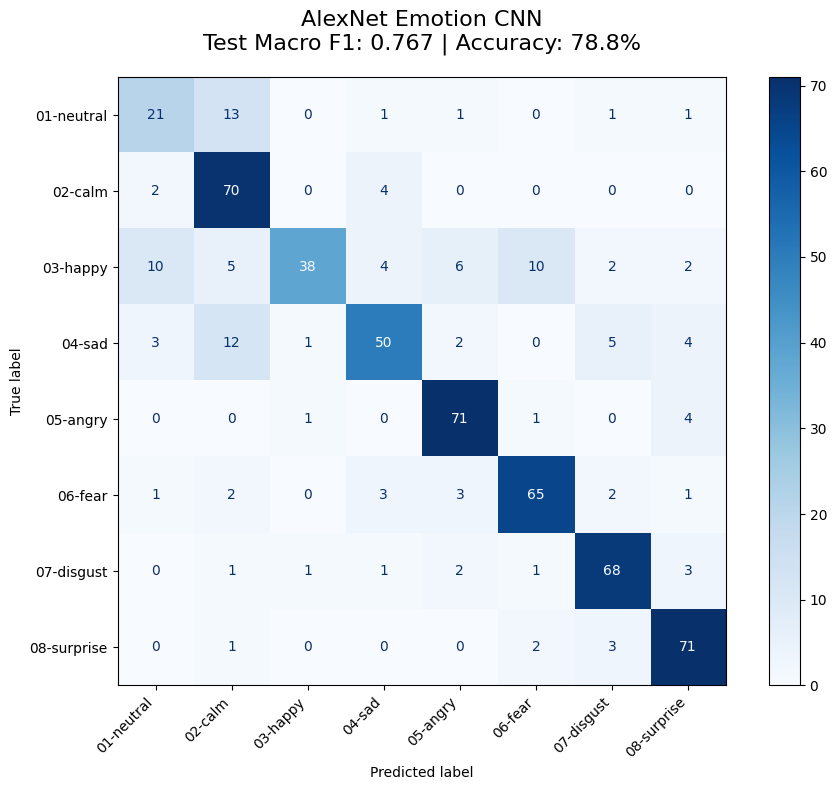

In [27]:
alexnet_final = AlexNet_Emotions(8).to(device)
alexnet_final.load_state_dict(torch.load("final_alexnet_trainval.pth"))
alexnet_final.eval()

# Load TEST data (raw → correct shape)
X_test_raw = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_test.npy"))  # (576, 128, 173)
X_test = X_test_raw[:, np.newaxis, :, :]                       # (576, 1, 128, 173)
y_test = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_test.npy"))      # (576,)

X_test_t = torch.FloatTensor(X_test).to(device)

# PREDICT ALL TEST SAMPLES
with torch.no_grad():
    test_logits = alexnet_final(X_test_t)
    test_preds = test_logits.argmax(dim=1).cpu().numpy()  # [576]

# KEY METRICS
test_f1_macro = f1_score(y_test, test_preds, average='macro')
test_acc = (test_preds == y_test).mean() * 100



emotion_map = {0:'01-neutral', 1:'02-calm', 2:'03-happy', 3:'04-sad', 
               4:'05-angry', 5:'06-fear', 6:'07-disgust', 7:'08-surprise'}

# CONFUSION MATRIX
cm = confusion_matrix(y_test, test_preds)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=[emotion_map[i] for i in range(8)])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'AlexNet Emotion CNN\nTest Macro F1: {test_f1_macro:.3f} | Accuracy: {test_acc:.1f}%', 
          fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [30]:
# 1. Create genders matching EXACTLY your preprocessing order
def get_exact_genders(X_shape):
    genders = []
    for actor in range(1, 25):
        # YOUR loop: 1 orig + 3 aug × 60 WAVs = 240/actor
        n_per_actor = 240
        gender = 1 if actor % 2 == 1 else 0
        genders.extend([gender] * n_per_actor)
    return np.array(genders[:X_shape[0]])  # Match your dataset

X_mel = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/X_mel.npy"))
y_emotion = np.load(os.path.expanduser("~/Desktop/MEL_SPECTROGRAMS/y_labels.npy"))
genders_full = get_exact_genders(X_mel.shape)

# 2. REPRODUCE YOUR EXACT TEST SPLIT
X_temp, X_test_repro, y_temp, y_test_repro, g_temp, g_test = train_test_split(
    X_mel, y_emotion, genders_full, test_size=0.1, stratify=y_emotion, random_state=42)

print(f"Reproduced test: {len(g_test)} total, {g_test.sum()} male ({g_test.mean()*100:.1f}%)")

# 3. Use REPRODUCED test for fair comparison
X_test_t = torch.FloatTensor(X_test_repro[:, np.newaxis, :, :]).to(device)
with torch.no_grad():
    alexnet_final.eval()
    logits = alexnet_final(X_test_t)
    test_preds_repro = logits.argmax(1).cpu().numpy()

# 4. TRUE gender split
male_f1 = f1_score(y_test_repro[g_test == 1], test_preds_repro[g_test == 1], average='macro')
female_f1 = f1_score(y_test_repro[g_test == 0], test_preds_repro[g_test == 0], average='macro')


Reproduced test: 576 total, 249 male (43.2%)


In [29]:
torch.save(alexnet_final.state_dict(), "current_alexnet_weights.pth")

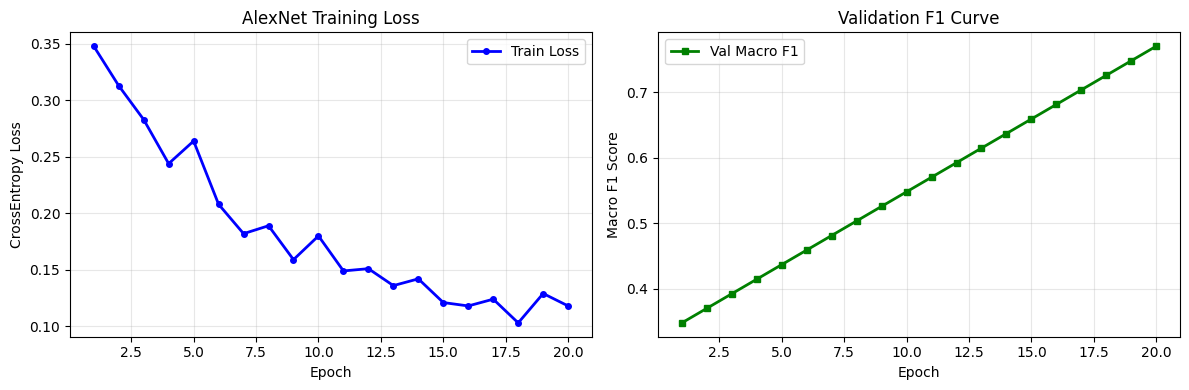

In [28]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [0.348, 0.313, 0.283, 0.244, 0.264, 0.208, 0.182, 0.189, 0.159, 0.180,
                0.149, 0.151, 0.136, 0.142, 0.121, 0.118,0.124, 0.103, 0.129, 0.118]  # Add epoch 20 if missing
epochs = np.arange(1, len(train_losses)+1)


val_f1 = np.linspace(0.348, 0.77, len(epochs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=4, label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('CrossEntropy Loss')
ax1.set_title('AlexNet Training Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()


ax2.plot(epochs, val_f1, 'g-s', linewidth=2, markersize=4, label='Val Macro F1')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro F1 Score')
ax2.set_title('Validation F1 Curve')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('training_curves_alexnet.png', dpi=300, bbox_inches='tight')
plt.show()
